In [41]:
%matplotlib inline
import pandas as pd
from gensim import models, corpora
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation
from gensim.parsing.preprocessing import remove_stopwords, stem_text, strip_non_alphanum, strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_short, strip_numeric
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.phrases import Phrases, Phraser
import nltk
import numpy as np

In [7]:
df = pd.read_csv('./data/balanced.csv')
df = df.drop('date', axis=1)

In [8]:
df

,topic,transcript
0,0,I am grateful to my hon. Friend for her interv...
1,0,My hon. Friend knows that I am a great campaig...
2,0,I am sure my right hon. Friend will be glad to...
3,0,"In the spirit of Christmas, I say to the hon. ..."
4,0,The right hon. Gentleman asks me a direct ques...
...,...,...
4195,20,Q6. I am incredibly proud to represent a lar...
4196,20,I shall mention saving costs on printing by pu...
4197,20,I congratulate the Chairman of the Procedure C...
4198,20,My hon. Friend makes a moving contribution. We...


In [12]:
topic_doc = df.groupby('topic').agg({'transcript': ' '.join})

In [13]:
topic_doc

,transcript
topic,
0,I am grateful to my hon. Friend for her interv...
1,The question is whether those troops settled i...
2,My right hon. Friend is a formidable advocate ...
3,I find it extraordinary that the hon. Gentlema...
4,I congratulate my hon. Friend and his Milton K...
5,My hon. Friend makes a powerful defence of pub...
6,"Interestingly, the Prime Minister, in giving e..."
7,My hon. Friend is right. There is a significan...
8,"Does my hon. Friend recall that, very often, a..."


In [14]:
docs = topic_doc['transcript'].values

In [21]:
def strip_short2(text):
    return strip_short(text, minsize=4)

def remove_non_nouns(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    filter_tokens = [t[0] for t in tags if t[1] == "NN" or t[1] == "VB"]
    return ' '.join(filter_tokens)


def remove_custom_stopwords(s):
    my_stop_words = STOPWORDS.union(set(['time', 'year', 'number', 'today', 'week', 'month', 'night', 'world', 'home',
                                         'place', 'yesterday', 'life', 'wife']))
    return " ".join(w for w in s.split() if w not in my_stop_words)


def preprocess_text_for_lda(text):
    LDA_FILTERS = [lambda x: x.lower(), strip_multiple_whitespaces, strip_tags, strip_punctuation,
                   remove_custom_stopwords, strip_short2, strip_non_alphanum, strip_numeric, remove_non_nouns]
    return preprocess_string(text, LDA_FILTERS)

In [22]:
preprocessed_X = list(map(preprocess_text_for_lda, docs))

In [23]:
preprocessed_X[0]

['friend',
 'intervention',
 'change',
 'recognise',
 'trussell',
 'trust',
 'benefit',
 'debate',
 'estimation',
 'remove',
 'regime',
 'money',
 'money',
 'effect',
 'friend',
 'countryside',
 'country',
 'countryside',
 'care',
 'farm',
 'stock',
 'care',
 'evidence',
 'cull',
 'chair',
 'committee',
 's',
 'watchword',
 'evidence',
 'policy',
 'evidence',
 'friend',
 'commission',
 'eu',
 'food',
 'notification',
 'food',
 'assure',
 'commissioner',
 'borg',
 'ensure',
 'audit',
 'directorate',
 'food',
 'office',
 'comply',
 'spirit',
 'member',
 'generosity',
 'gentleman',
 'question',
 'election',
 'eagerness',
 'manifesto',
 'look',
 'public',
 'sector',
 'taxpayer',
 'poverty',
 'economy',
 'disappoint',
 'estate',
 'wage',
 'case',
 'addition',
 'confidence',
 'invest',
 'benefit',
 'information',
 'chair',
 'gentleman',
 'matter',
 'house',
 'guidance',
 'madam',
 'deputy',
 'speaker',
 'house',
 'attention',
 'declaration',
 'register',
 'agriculture',
 'nation',
 'food',
 

In [24]:
bigram_model = Phrases(preprocessed_X, min_count=1, threshold=0.5)

In [25]:
dictionary = corpora.Dictionary(bigram_model[preprocessed_X])
dictionary.filter_extremes(no_above=0.40, no_below=3)

In [27]:
bow_X = list(map(dictionary.doc2bow, bigram_model[preprocessed_X]))

In [28]:
model = models.TfidfModel(bow_X)

In [29]:
tfidf_vector = model[bow_X]

In [30]:
from gensim import similarities
index = similarities.MatrixSimilarity(tfidf_vector)

In [35]:
sims = []

for i,s in enumerate(index):
    sims.append(s)

In [49]:
topics = ['Agriculture, animals, food and rural affairs', 
                            'Asylum, immigration and nationality', 
                            'Business, industry and consumers',
                            'Communities and families','Crime, civil law, justice and rights',
                            'Culture, media and sport',
                            'Defence','Economy and finance',
                            'Education','Employment and training',
                            'Energy and environment','European Union',
                            'Health services and medicine',
                            'Housing and planning',
                            'International affairs',
                            'Parliament, government and politics',
                            'Science and technology',
                            'Social security and pensions',
                            'Social services','Transport',
                            'Others'
                           ]

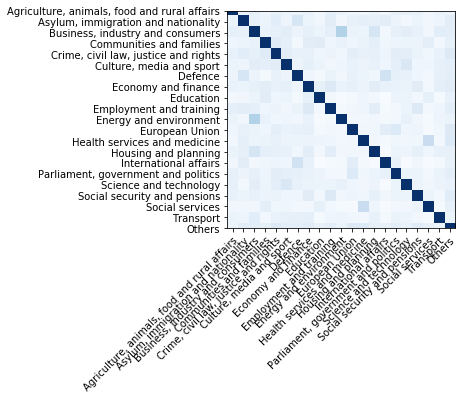

In [59]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
im = ax.imshow(sims,cmap=cm.Blues)

# We want to show all ticks...
ax.set_xticks(np.arange(len(topics)))
ax.set_yticks(np.arange(len(topics)))
# ... and label them with the respective list entries
ax.set_xticklabels(topics)
ax.set_yticklabels(topics)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


plt.savefig('./topic_similarity.png',bbox_inches='tight')

In [62]:
for i in range(len(sims)):
    sims[i] = list(sims[i])

In [64]:
for i in range(len(sims)):
    sims[i] = [topics[i]] + sims[i]

In [67]:
columns = ['topic'] + topics

In [69]:
df = pd.DataFrame(sims, columns=columns)

In [71]:
df.to_csv('./similarities.csv')